In [329]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.layers.embeddings import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Bidirectional


## Install `Tensorflow2.0` 

In [330]:
# !!pip uninstall tensorflow

In [331]:
# !pip install tensorflow==2.0.0

## Get Required Files from Drive

In [332]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Set your project path 

import os
os.chdir('/content/drive/My Drive/Twitter Dataset')

#**## Reading and Exploring Data**

## Read Data "Twitter-Data.csv". Explore the data and get  some insights about the data.
Hint - As its in json format you need to use pandas.read_json function. Give paraemeter lines = True.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('Twitter_Data.csv')

In [ ]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [ ]:
df.clean_text= df.clean_text.astype(str)

In [ ]:
df.groupby('category').count().T / df['category'].count()

category,-1.0,0.0,1.0
clean_text,0.217889,0.338786,0.443325


## Missing points in data

In [ ]:
df.isnull().sum()

clean_text    0
category      7
dtype: int64

In [ ]:
# Treating missing values by dropping them
df = df.dropna(how='any',axis=0)
df.isnull().sum()

clean_text    0
category      0
dtype: int64

### Visualizing word cloud for clean_text

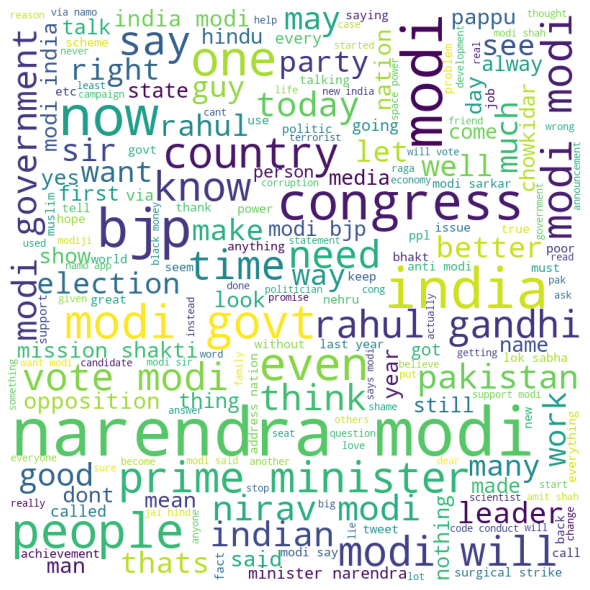

In [ ]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df['clean_text']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Let's look at the MOST USED WORDS in "clean_text"

In [ ]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  return d
# print 100 most frequent words 

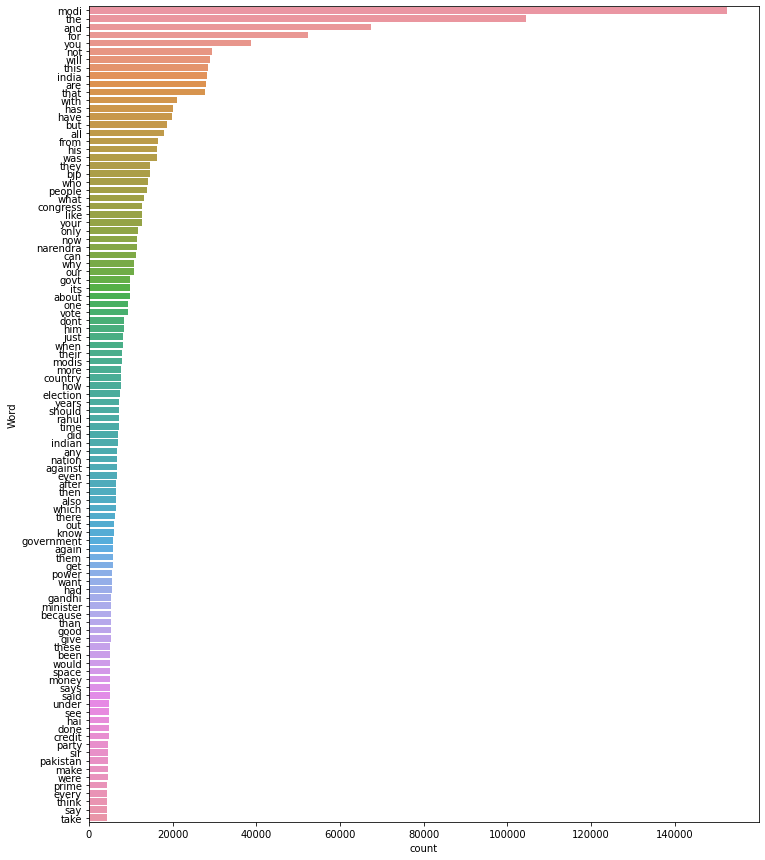

In [ ]:
d = freq_words(df['clean_text'], 100)

##### When we look at the most used words distribution across clean_text, one can notice that there are some "similar words" and has lot of "verbs, articles, adjectives" etc. 
##### This shows how pretext processing is essential before we can build the models and especially extensive processing is required for Combined Description.

## **Text preprocessing, Creating word vocabulary from the corpus of report text data and Creating tokens as required**

#### In a NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Let's create a function which will perform the following tasks on the text columns:

1. Make text lowercase,
2. removes hyperlinks,
3. remove punctuation
4. removes numbers
5. tokenizes
6. removes stopwords
7. Disclaimer statements
8. Text Translation to English

### Using nltk for removing stop words, converting nltk tag to wordnet tag & lemmatization

In [ ]:
from contextlib import redirect_stdout
with redirect_stdout(open(os.devnull, "w")):             ### Silence download progressing by re-directing to stdout
   nltk.download('stopwords')
   nltk.download('punkt')
   nltk.download('averaged_perceptron_tagger')
   nltk.download('wordnet')
   from nltk.corpus import stopwords

In [ ]:
stop = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

In [ ]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [ ]:
#lemmatization 
def lemmatize_sentence(sentence):

    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    
    #tuple of (token, wordnet_tag)

    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
# function to identify & remove unwanted characters from text in "clean_text"
temp =[]
for sentence in df["clean_text"]:
    sentence = sentence.lower() #lower case
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #removing HTML tags
    sentence = re.sub(r'\S+@\S+', 'EmailId', sentence)#removing mail ids
    sentence = re.sub(r'\S+@\S+', 'https', sentence)#removing https
    sentence = re.sub(r'\S+@\S+', 'http', sentence)#removing http
    sentence = re.sub(r'\'', '', sentence, re.I|re.A)
    sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A)
    sentence = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'com ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'Subject: ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'\[cid:(.*)]', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'hello ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'The information(.*)infection', ' ', sentence, re.I|re.A)  # footer
    sentence = re.sub(r'Endava Limited is a company(.*)or omissions', ' ', sentence,  re.I|re.A)  # footer
    sentence = re.sub(r'The information in this email is confidential and may be legally(.*)interference if you are not the intended recipient', ' ', sentence, re.I|re.A)  # footer
    sentence = re.sub(r'select the following link to view the disclaimer in an alternate language.', ' ', sentence, re.I|re.A)  # disclaimer footer
    l_sentence = lemmatize_sentence(sentence)

    words = [word for word in l_sentence.split() if word not in stopwords.words('english')]
    temp.append(words)
    #print ("Sentence = ",sentence)

In [ ]:
#storing the transformed text
df["clean_text"] = temp

In [ ]:
#Additional text cleaning - We noticed that several rows still have junk characters that will have to be removed
df = df[df['clean_text'].map(lambda d: len(d)) > 0]

In [ ]:
#join the words list back
df['clean_text']=[" ".join(description) for description in df['clean_text'].values]

In [ ]:
df.to_csv("trans_text.csv")

In [ ]:
df = pd.read_csv('trans_text.csv', usecols= ["clean_text", "category"] )

In [ ]:
df.clean_text= df.clean_text.astype(str)

In [ ]:
df.head()

,clean_text,category
0,modi promise minimum government maximum govern...,-1.0
1,talk nonsense continue drama vote modi,0.0
2,say vote modi welcome bjp tell rahul main camp...,1.0
3,ask supporter prefix chowkidar name modi great...,1.0
4,answer among powerful world leader today trump...,1.0


## Visualizing post Text processing & Cleaning

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


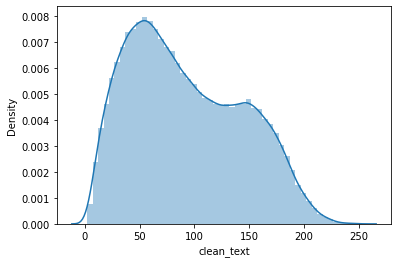

In [ ]:
sns.distplot(df['clean_text'].str.len())

## Word Cloud Visualization

### Word Cloud Visualization for "clean_text"

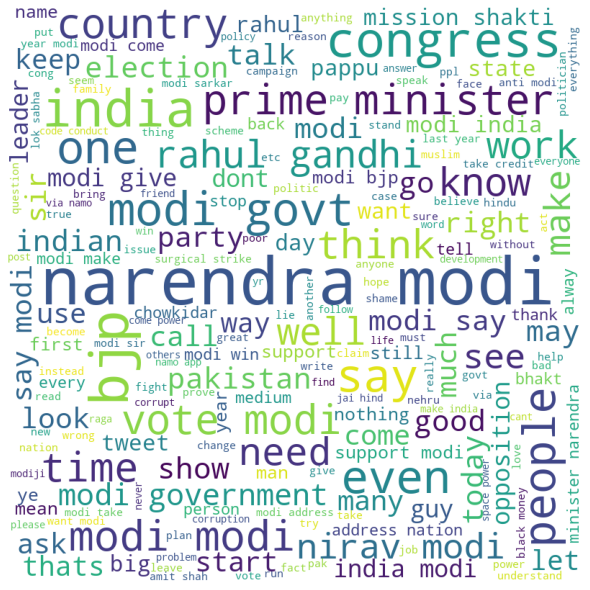

In [ ]:
# Python program to generate WordCloud 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df['clean_text']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Get the Length of each line and find the maximum length.
As different lines are of different length. We need to pad the our sequences using the max length.

In [ ]:
print (df["clean_text"].str.len().max())

252


#**## Modelling**

## Import required modules required for modelling.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

# Set Different Parameters for the model.

In [ ]:
max_features = 10000
maxlen = 252              ## Add your max length here ##
embedding_size = 200

## Apply Keras Tokenizer of headline column of your data. 
Hint - First create a tokenizer instance using Tokenizer(num_words=max_features) 
And then fit this tokenizer instance on your data column df['headline'] using .fit_on_texts()

In [ ]:
tokenizer = Tokenizer(num_words=max_features) 

In [ ]:
tokenizer.fit_on_texts(df['clean_text'])

# Define X and y for your model.

In [ ]:
X = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(df['category'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 162893
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 

## Get the Vocabulary size
Hint : You can use tokenizer.word_index.

In [ ]:
voc_size = len(tokenizer.word_index) + 1
print (voc_size)

93974


#**## Word Embedding**

## Get Glove Word Embeddings

In [ ]:
#Set your project path 

import os
os.chdir('/content/drive/My Drive/Sarcasm_detection')

In [ ]:
glove_file = "glove.6B.zip"

In [ ]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

# Get the Word Embeddings using Embedding file as given below.

In [ ]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd



# Create a weight matrix for words in training docs

In [ ]:
num_words = voc_size

In [ ]:
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

## Create and Compile your Model
Hint - Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.


In [ ]:
### Embedding layer for hint 
## model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
### Bidirectional LSTM layer for hint 
## model.add(Bidirectional(LSTM(128, return_sequences = True)))

n_timesteps = 10

model = Sequential()
e = Embedding(voc_size, 200, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1)))
model.add(Dropout(0.50))
model.add(Flatten())
model.add(Dense(1, activation='softmax'))


In [ ]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 252, 200)          18794800  
_________________________________________________________________
bidirectional (Bidirectional (None, 252, 40)           35360     
_________________________________________________________________
dropout (Dropout)            (None, 252, 40)           0         
_________________________________________________________________
flatten (Flatten)            (None, 10080)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10081     
Total params: 18,840,241
Trainable params: 45,441
Non-trainable params: 18,794,800
_________________________________________________________________
None


# Fitting the model with a batch size of 100 and validation_split = 0.2. and state the validation accuracy


In [ ]:
batch_size = 100
epochs = 10

## Add your code here ##

In [ ]:
model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=True)

Epoch 1/10
1304/1304 [==============================] - 32s 25ms/step - loss: nan - accuracy: 0.3384 - val_loss: nan - val_accuracy: 0.3387
Epoch 2/10
1304/1304 [==============================] - 32s 25ms/step - loss: nan - accuracy: 0.3384 - val_loss: nan - val_accuracy: 0.3387
Epoch 3/10
1304/1304 [==============================] - 32s 25ms/step - loss: nan - accuracy: 0.3384 - val_loss: nan - val_accuracy: 0.3387
Epoch 4/10
1304/1304 [==============================] - 32s 25ms/step - loss: nan - accuracy: 0.3384 - val_loss: nan - val_accuracy: 0.3387
Epoch 5/10
1304/1304 [==============================] - 32s 25ms/step - loss: nan - accuracy: 0.3384 - val_loss: nan - val_accuracy: 0.3387
Epoch 6/10
1304/1304 [==============================] - 32s 25ms/step - loss: nan - accuracy: 0.3384 - val_loss: nan - val_accuracy: 0.3387
Epoch 7/10
1304/1304 [==============================] - 32s 25ms/step - loss: nan - accuracy: 0.3384 - val_loss: nan - val_accuracy: 0.3387
Epoch 8/10
1304/1304

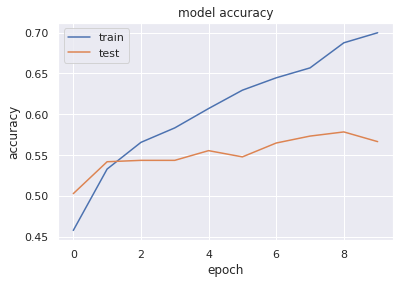

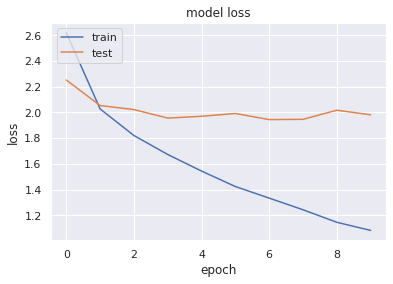

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Setting up Paramaters for Multinomial Naive Bayes Model

In [ ]:
column_to_predict = "category"
text_columns = "clean_text"
classifier = "NB"  # Supported algorithms # "SVM" # "NB"
use_grid_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = True  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = False  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 1  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1


### Prepare data and labels and split them to train and test sets


In [ ]:
data = df[text_columns]
labelData = df[column_to_predict]

# Split dataset into training and testing data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labelData, test_size=0.2
)  # split data to train/test sets with 80:20 ratio

In [ ]:
print (len(train_data), len(test_data), len(train_labels), len(test_labels))

130314 32579 130314 32579


### Extracting features from text using CountVectorizer and TF-IDF transformer

In [ ]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [ ]:
# Count vectorizer
if remove_stop_words:
    count_vect = CountVectorizer(stop_words=stop_words_lang)
elif use_stemming:
    count_vect = StemmedCountVectorizer(stop_words=stop_words_lang)
else:
    count_vect = CountVectorizer()

vectorized_data = count_vect.fit_transform(train_data)
vectorized_data.shape

(130314, 81436)

In [ ]:
tfidf = TfidfTransformer()
features = tfidf.fit_transform(vectorized_data)
features.shape

(130314, 81436)


### Using pipeline to preprocess data and train classifier

In [ ]:
# Fitting the training data into a data processing pipeline and eventually into the model itself
if classifier == "NB":
    print("Training NB classifier")
    # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
    # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
    # We will be using the 'text_clf' going forward.

    text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(fit_prior=fit_prior))
    ])
    text_clf = text_clf.fit(train_data, train_labels)

Training NB classifier


### Use GridSearchCV to search for best set of parameters

In [ ]:
if use_grid_search:
    # Grid Search
    # Here, we are creating a list of parameters for which we would like to do performance tuning.
    # All the parameters name start with the classifier name (remember the arbitrary name we gave).
    # E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

    # NB parameters
    parameters = {
        'vect__ngram_range': [(1, 1), (2, 2)],
        'tfidf__use_idf': (True, False),
        'clf__alpha': (1e-2, 1e-3)
    }

    # Next, we create an instance of the grid search by passing the classifier, parameters
    # and n_jobs=-1 which tells to use multiple cores from user machine.
    gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(train_data, train_labels)
    

In [ ]:
# To see the best mean score
gs_clf.best_score_

0.6627760474004547

In [ ]:
# To see the best parm
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}

In [ ]:
print("Evaluating model")
# Score and evaluate model on test data using model without hyperparameter tuning
predicted = text_clf.predict(test_data)
prediction_acc = np.mean(predicted == test_labels)
print("Confusion matrix without GridSearch:")
print(metrics.confusion_matrix(test_labels, predicted))
print("Mean without GridSearch: " + str(prediction_acc))

Evaluating model
Confusion matrix without GridSearch:
[[  907   369  5812]
 [   52  3760  7213]
 [   40   429 13997]]
Mean without GridSearch: 0.5728843733693484


In [ ]:
# Score and evaluate model on test data using model WITH hyperparameter tuning
if use_grid_search:
    predicted = gs_clf.predict(test_data)
    prediction_acc = np.mean(predicted == test_labels)
    print("Confusion matrix with GridSearch:")
    print(metrics.confusion_matrix(test_labels, predicted))
    print("Mean with GridSearch: " + str(prediction_acc))

Confusion matrix with GridSearch:
[[ 2719   719  3650]
 [  425  6327  4273]
 [  614  1149 12703]]
Mean with GridSearch: 0.6675772737039197


### Ploting confusion matrix

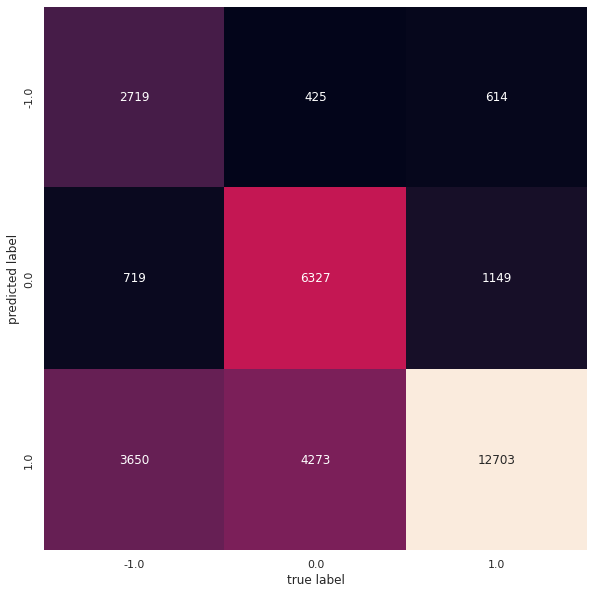

In [ ]:
# Ploting confusion matrix with 'seaborn' module
# Use below line only with Jupyter Notebook

mat = confusion_matrix(test_labels, predicted)
plt.figure(figsize=(10, 10))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

## State of the Art Model 1 - **BERT**

### Let’s set up the environment.

In [333]:
!pip install -q transformers --quiet

### Import Libraries

In [334]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

#### The current versions of the fastai and transformers libraries are respectively 1.0.61 and 4.11.3.

In [335]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 4.11.3


### Original Data and Extracting the required features for modelling

In [336]:
#Set your project path 

import os
os.chdir('/content/drive/My Drive/Twitter Dataset')

In [337]:
df = pd.read_csv('trans_text.csv', usecols= ["clean_text", "category"] )

In [338]:
df.clean_text= df.clean_text.astype(str)

In [339]:
clean_text = df.copy (deep=False)

### Function to split Train and Test sets 

In [340]:
def split_train_valid_test(data,valid_ratio,test_ratio):
    shuffled_indcies=np.random.permutation(len(data))
    valid_set_size= int(len(data)*valid_ratio)
    valid_indcies=shuffled_indcies[:valid_set_size]
    test_set_size= int(len(data)*test_ratio)
    test_indcies=shuffled_indcies[valid_set_size:test_set_size+valid_set_size]
    train_indices=shuffled_indcies[test_set_size:]
    return data.iloc[train_indices],data.iloc[valid_indcies],data.iloc[test_indcies]

train_set,valid_set,test_set=split_train_valid_test(clean_text,valid_ratio=0.2,test_ratio=0.2)

In [341]:
print(len(train_set),len(test_set))  # Counts of Train and Test Sets

130315 32578


In [342]:
train_set.head()

,clean_text,category
48078,yes definitely talk bar girl call modi maut sa...,0.0
97517,sample see people follow narendra modi twitter...,0.0
127925,welcome small city gohpur honorable prime mini...,1.0
27285,take care people gujarat lutere congresson sin...,1.0
34944,building well infrastructure good life,1.0


In [362]:
test_set.head()

,clean_text,category
48078,yes definitely talk bar girl call modi maut sa...,0.0
97517,sample see people follow narendra modi twitter...,0.0
127925,welcome small city gohpur honorable prime mini...,1.0
27285,take care people gujarat lutere congresson sin...,1.0
34944,building well infrastructure good life,1.0


### Time to get the data ready for Transformer models

In [363]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

### Setting up the parms

In [364]:
# Parameters
seed = 42
use_fp16 = False
bs = 8

#model_type = 'roberta'
#pretrained_model_name = 'roberta-base'

model_type = 'bert'
pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

Assigning required classes for transformer model architechture

In [365]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

### Print the available values for pretrained_model_name corresponding to the model_type used.

In [366]:
print(model_class) # Since we are passing Roberta model in the paramters, we can see model_class has assumed Roberta model type 

<class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>


### Function to set the seed for generating random numbers

In [367]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [368]:
## Calling the seed_all function

seed_all(seed)

#### Defining a Class for Custom Tokenization to inherit from base tokenizer as there are lot of classes wrapped in each other.

In [369]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = 512
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens


#### Tokenizing from the pre-trained model

In [370]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

### Custom Numericalizer
In fastai, NumericalizeProcessor object takes as vocab argument a Vocab object. 

So, we are creating a new class TransformersVocab that inherits from Vocab and overwrite numericalize and textify functions. 

It consists of using the functions convert_tokens_to_ids and convert_ids_to_tokens in respectively numericalize and textify

In [371]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

#### The functions __gestate__ and __setstate__ allow the functions export and load_learner to work correctly with TransformersVocab.

### Custom processor
Now that we have our custom tokenizer and numericalizer, we can create the custom processor. 

We are passing the include_bos = False and include_eos = False options. This is because fastai adds its own special tokens by default which interferes with the [CLS] and [SEP] tokens added by our custom tokenizer.

In [372]:

transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

### Setting up the Databunch

As mentioned in the HuggingFace documentation, BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [373]:
pad_first = bool(model_type in ['bert'])
pad_idx = transformer_tokenizer.pad_token_id

In [374]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']
[16183, 4904, 1039, 9765, 25175, 1010, 7592, 2009, 1055, 2033]


['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']

There is multible ways to create a DataBunch, in our implementation, we use the data block API, which gives more flexibility.

In [375]:
def main():
  databunch = (TextList.from_df(train_set, cols = 'clean_text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols = 'category')
             .add_test(test_set)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

if __name__ == '__main__':
    main()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


#### Check batch and tokenizer :

In [376]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()


[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
[CLS] mod ##i pl ##z check institute nehru build dr ##do csi ##r bar ##c ap ##sar ##a inc ##os ##par is ##ro np ##l ii ##t ii ##st io ##fs on ##gc ai ##im ##s ii ##m ni ##t bo ##kar ##o rourke ##la steel cd ##ri cb ##ri ce ##cr ##i ce ##eri cf ##tri c ##gc ##ri ci ##ma ##p cl ##ri cm ##eri cr ##ri csi,0.0
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [CLS] really unemployed seem quite mature bear mod ##i era it ##na pad let ##a na ##uk ##ri mil ja ##ati au ##r ku ##ch nah ##in ol ##a cha ##la let ##a le ##kin congress ##i cho ##ron par bank b ##hi b,1.0
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [CLS] ya ##hi fr ##k hai bjp congress bjp mod ##i b ##hak ##t ke ##hl ##ate congress cha ##mc ##he bjp ga ##uta ##m ga ##mber jai ##se des ##h b ##hak ##t join hot ##e congress,0.0
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [CLS] well say chow ##ki ##dar shri pi ##yu ##sh congress ##in ##c couldn ##t digest fact people mandate reign non ##dy ##nas ##t non ##con ##gre ##ss chow ##ki ##dar shri na ##ren ##dra mod ##i prime,1.0
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [CLS] ha ##an the ##kh hai ##n ky ##u tha ##ak ra ##ha hai ##n ki ##s ##ne ky ##a launch ki ##ya eventually main mission successful hua due hard work scientist back na ##ren ##dra mod,1.0


#### Check batch and numericalizer 

In [377]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 101
[SEP] id : 102
[PAD] id : 0
Batch shape :  torch.Size([8, 87])
tensor([[  101, 16913,  2072, 20228,  2480,  4638,  2820, 23556,  3857,  2852,
          3527, 22174,  2099,  3347,  2278,  9706, 10286,  2050,  4297,  2891,
         19362,  2003,  3217, 27937,  2140,  2462,  2102,  2462,  3367, 22834,
         10343,  2006, 18195,  9932,  5714,  2015,  2462,  2213,  9152,  2102,
          8945,  6673,  2080, 24400,  2721,  3886,  3729,  3089, 17324,  3089,
          8292, 26775,  2072,  8292, 11124, 12935, 18886,  1039, 18195,  3089,
         25022,  2863,  2361, 18856,  3089,  4642, 11124, 13675,  3089, 22174,
          2080, 20116, 12458,  3089,  6187,  2480,  3089,  2154,  8294,  4647,
         18153,  1061,  3367, 17460,  7547,  3519,   102],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,   101,  4687,  2296,  1056, 2

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### Custom model

While Migrating from pytorch-pretrained-bert to transformers, every model's forward method always outputs a "tuple" with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits.  One way to access them is to create a custom model.

In [378]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

#### To make our transformers adapted to multiclass classification, before loading the pre-trained model, we need to precise the number of labels.

In [379]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 74
config.use_bfloat16 = use_fp16
print(config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
    "32": "LABEL_32",
    "33": "LABEL_33",
    "34": "LABE

### Setting the configuration to the model

In [380]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 74)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Learner : Custom Optimizer / Custom Metric

In pytorch-transformers, HuggingFace had implemented two specific optimizers  -  BertAdam and OpenAIAdam  -  that have been replaced by a single AdamW optimizer. This optimizer matches Pytorch Adam optimizer Api, therefore, it becomes straightforward to integrate it within fastai. For reproducing BertAdam specific behavior, we are setting correct_bias = False.

In [381]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = None
gc.collect()

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

### Discriminative Fine-tuning and Gradual unfreezing

To use discriminative layer training and gradual unfreezing, fastai provides one tool that allows to "split" the structure model into groups.

Unfortunately, the model architectures are too different to create a unique generic function that can "split" all the model types in a convenient way. Thereby, we are going to implement a custom "split".

In our case, if we use the RobBERTa model and that we observe his architecture by making print(learner.model).

In [382]:
print(learner.model)

CustomTransformerModel(
  (transformer): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

#### We can decide to divide the model in 14 blocks :

  * 1 Embedding

  * 12 transformer

  * 1 classifier

In this case, we can split our model in this way :

In [383]:
# For bert-base
list_layers = [learner.model.transformer.bert.embeddings,
              learner.model.transformer.bert.encoder.layer[0],
              learner.model.transformer.bert.encoder.layer[1],
              learner.model.transformer.bert.encoder.layer[2],
              learner.model.transformer.bert.encoder.layer[3],
              learner.model.transformer.bert.encoder.layer[4],
              learner.model.transformer.bert.encoder.layer[5],
              learner.model.transformer.bert.encoder.layer[6],
              learner.model.transformer.bert.encoder.layer[7],
              learner.model.transformer.bert.encoder.layer[8],
              learner.model.transformer.bert.encoder.layer[9],
              learner.model.transformer.bert.encoder.layer[10],
              learner.model.transformer.bert.encoder.layer[11],
              learner.model.transformer.bert.pooler]

### Check groups :

In [384]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(30522, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): Embedding(2, 768)
  (3): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_fea

### Train the Model

Now we can finally use all the fastai build-in features to train our model. Like the ULMFiT method, we will use Slanted Triangular Learning Rates, Discriminate Learning Rate and gradually unfreeze the model.

In [385]:
learner.save('untrain')

In [386]:
seed_all(seed)
learner.load('untrain');

#### Therefore, we first freeze all the groups but the classifier with :

In [387]:
learner.freeze_to(-1)

### We check which layer are trainable.

In [388]:
learner.summary()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [87, 768]            23,440,896 False     
______________________________________________________________________
Embedding            [87, 768]            393,216    False     
______________________________________________________________________
Embedding            [87, 768]            1,536      False     
______________________________________________________________________
LayerNorm            [87, 768]            1,536      False     
______________________________________________________________________
Dropout              [87, 768]            0          False     
______________________________________________________________________
Linear               [87, 768]            590,592    False     
______________________________________________________________________
Linear               [87, 768]            590,592    False     
_______________________________________

### For Slanted Triangular Learning Rates we need to use the function one_cycle. For more information please check the fastai documentation here. 

#### To use our one_cycle we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using lr_find.

In [389]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([592])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: ignored

# **Conclusion**:

### According to analysis of different models, Multinomial naives model had a better Accuracy of 66.75%

### Bi directional LSTM has an accuracy of just 33 %

### With state of the ART BERT model, stuck in an issue during training the model. Might need more time to investigate and fix it. I hope BERT could perform far better than the traditional Multinomial naves algorithm.

# **Next Steps**

In the course of our journey, there were several ideas and trials that
didn’t materialize into the final notebook. I found, however, that
even these failed attempts taught me a lot, and some of them could
possibly be worked upon in the future.


1) Topic Modelling
In machine learning and natural language processing, a topic model
is a type of statistical model for discovering the abstract "topics" that
occur in a collection of documents. It identifies recurring patterns in
the text. This method, however, was too complex for the application at
hand, but will be an interesting tool to experiment with in the future

2) Oversampling
An attempt to use SMOTE oversampling was made, so as to overcome
the large imbalance in the data without losing out on and information.
This, however, resulted in two classes being deducted in the
oversampled dataset for unknown reasons. This dataset, hence, could
not be used as an input to the model.

3) K-fold cross validation
Cross validation is a method by which in every cycle, the data trains
and tests on a different subset of data.


